In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read datasets
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_train = pd.read_csv("order_products__train.csv")
order_test = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [60]:
# Creat fake e-mail for user_id
user = orders['user_id'].unique()
user_df = pd.DataFrame(user, columns = ['user_id'])
user_df['email'] = [f'user_{user}@gmail.com' for user in user_df['user_id']]
user_df.head()

,user_id,email
0,1,user_1@gmail.com
1,2,user_2@gmail.com
2,3,user_3@gmail.com
3,4,user_4@gmail.com
4,5,user_5@gmail.com


In [3]:
# Merge datasets
order = order_train.merge(orders, on=['order_id'], how = 'inner')
order = order.merge(products, on=['product_id'], how = 'inner')
order = order.merge(aisles, on=['aisle_id'], how = 'inner')
order_df = order.merge(departments, on=['department_id'], how = 'inner')
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [4]:
# Remove columns not needed
order_df = order_df.drop(columns = ['eval_set', 'order_number','order_dow'], axis =1)
order_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,47901,6,16.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,2993,7,7.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,41425,8,14.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,187205,14,30.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [5]:
# Check If There Are Repeat Customers
# Groupby User, Product ID and Product Name
top_user = order_df.groupby(['user_id','product_id','product_name']).size().reset_index(name = "count")
top_user = pd.DataFrame(top_user)

# Unique Values in Count Are 1 Meaning This Dataset is of Unique Customers
len(pd.unique(top_user['count']))

1

In [6]:
# Print Number of Aisles and Departments
print( len(pd.unique(order_df['aisle'])), len(pd.unique(order_df['department'])))

# Not many departments compare to aisles, to have our clusters be more details we'll focus on
# aisles for cluster customer segments

134 21


## Top Products in Aisle

In [7]:
# TOP Products in Aisle
top_aisle = order_df.groupby(['aisle_id','aisle','product_id','product_name']).size().reset_index(name = "count")
top_aisle = pd.DataFrame(top_aisle)
top_aisle.head()

,aisle_id,aisle,product_id,product_name,count
0,1,prepared soups salads,209,Italian Pasta Salad,8
1,1,prepared soups salads,554,Turkey Chili,56
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,1
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,5
4,1,prepared soups salads,2539,Original Potato Salad,33


In [8]:
# TOP 3 Products in Aisle
# Sort Descending on Count
top_aisle = top_aisle.sort_values(by='count', ascending = False)

# Sort Ascending on Aisle
top_aisle = top_aisle.sort_values(by='aisle_id')

# Get Unique aisle_id List
unique_aisle = pd.unique(top_aisle['aisle_id'])

# Get initial dataframe to concat
inital_df = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[0]].nlargest(3, columns='count')

# Creat for loop to concat top 3 product of each aisle
for i in range(1,len(unique_aisle)):
    top_3 = top_aisle.loc[top_aisle['aisle_id'] == unique_aisle[i]].nlargest(3, columns='count')
    inital_df = pd.concat([inital_df,top_3])
    
top3_aisle = inital_df
top3_aisle.head()

,aisle_id,aisle,product_id,product_name,count
61,1,prepared soups salads,26047,Tuna Salad,208
57,1,prepared soups salads,25199,Classic Chicken Salad,200
50,1,prepared soups salads,22281,Chicken Noodle Soup,165
293,2,specialty cheeses,37524,Fresh Mozzarella Ball,450
194,2,specialty cheeses,13409,Dubliner Wedge Pre Cut Cheese,253


In [9]:
# List of Repeated Purchases
reorder = order_df[order_df['reordered']==1]
reorder_df = reorder[['product_id', 'user_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']]
reorder_df.head()

,product_id,user_id,product_name,aisle_id,department_id,aisle,department
0,49302,112108,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,49302,47901,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,49302,2993,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,49302,41425,Bulgarian Yogurt,120,16,yogurt,dairy eggs
5,49302,199120,Bulgarian Yogurt,120,16,yogurt,dairy eggs


## Model (K-Means)

In [10]:
# Transform Table to be Percentage of Aisle Purchases For User
# Calculate Percentage of User
percent_user = order_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

,user_id,aisle_id,aisle,count,sum,percent
0,1,21,packaged cheese,1,11,0.090909
1,1,23,popcorn jerky,1,11,0.090909
2,1,45,candy chocolate,1,11,0.090909
3,1,53,cream,1,11,0.090909
4,1,54,paper goods,1,11,0.090909


In [11]:
# Create user product aisle percentage table
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.111111,0.222222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
# Model K-means
from sklearn.cluster import KMeans

distortions = []
for k in range(1,15):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(percent_df)
    distortions.append(kmeanModel.inertia_)

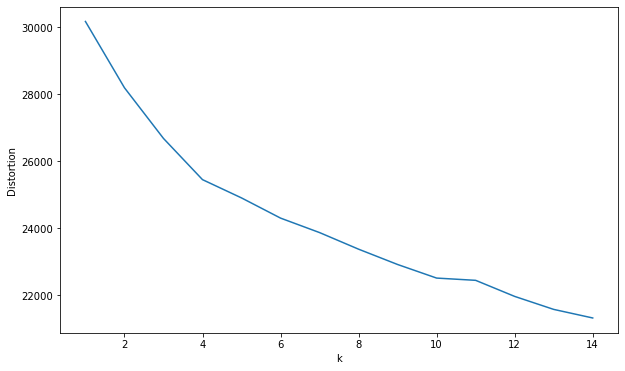

In [13]:
# Plot Distortion to Determine Elbow/Optimal k-value
plt.figure(figsize=(10,6))
plt.plot(range(1,15), distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

# Elbow is around 6, some of these aisle are similar to each other so we'll use PCA
# to redefine features to better predict clusters

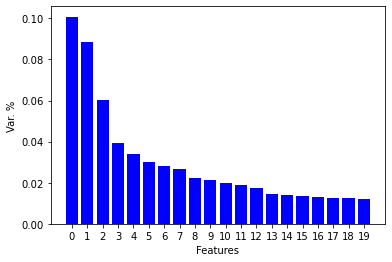

In [14]:
# PCA (PRINCIPAL COMPONENT ANALYSIS)
# Determine optimal n components
# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(percent_df)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Features')
plt.ylabel('Var. %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

# Variance drop off is at 3

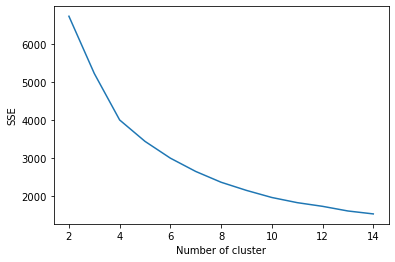

In [16]:
# Fit Model with k-mean clustering and PCA
sse = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3]])
    sse[k]= kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# 6 is still the optimal cluster # so we will continue with 3 components and 6 clusters.

In [17]:
# Fit model k-mean with 6 clusters, and PCA with 3 components
kmeans = KMeans(n_clusters = 6).fit(PCA_components[[0,1,2,3]])
cluster_label = kmeans.labels_

In [18]:
# Pivot Count For User and Aisle
percent_ct = pd.pivot_table(percent_user, values='count', index='user_id', columns = 'aisle', fill_value = 0 )
# Add Cluster Labels to Dataframe To Identify Customer Segment
percent_ct['cluster'] = kmeans.labels_
# Display preview
percent_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,4


In [19]:
# Sum Count of Bought Products in Aisle
cluster_summary = percent_ct.groupby('cluster').sum()
cluster_summary = cluster_summary.reset_index(drop=False)
cluster_summary.head()

aisle,cluster,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,816,3228,176,197,7612,882,7199,742,185,...,6207,5561,2054,3939,952,1150,1026,16009,831,27124
1,1,106,1335,75,68,3629,289,2631,147,41,...,3119,1969,1168,2034,312,227,465,7554,103,15932
2,2,59,667,23,31,837,155,1008,68,31,...,1163,665,572,806,97,104,196,3085,67,4525
3,3,3,24,0,1,7,4,34,5,1,...,48,102,5,3,19,17,17,5780,9,113
4,4,75,1727,32,31,1087,154,2144,130,28,...,1483,1019,1308,1542,63,113,252,3844,77,7122


In [20]:
# Unpivot table 
df_unpivoted = cluster_summary.melt(id_vars=['cluster'], var_name='aisle', value_name='count')
df_unpivoted = df_unpivoted.sort_values('count', ascending = False)
df_unpivoted.head()

,cluster,aisle,count
322,4,fresh vegetables,83596
301,1,fresh fruits,73968
319,1,fresh vegetables,30016
590,2,packaged vegetables fruits,28915
304,4,fresh fruits,28255


In [21]:
# Calculate Cluster Aisle Sum/Total
cluster_ttl = pd.DataFrame(cluster_summary.sum(axis=1), columns=['total'])

# Determine Percentage of Aisle in Cluster
percent_cluster=[]
for i in range(6):
    filter_df = df_unpivoted[df_unpivoted['cluster'] == i].reset_index(drop=True)
    filter_df['percent'] = filter_df['count']/cluster_ttl['total'][i]
    percent_cluster.append(filter_df)

percent_cluster = pd.concat(percent_cluster)
percent_cluster.head()

,cluster,aisle,count,percent
0,0,yogurt,27124,0.046195
1,0,fresh vegetables,22793,0.038819
2,0,fresh fruits,21851,0.037214
3,0,packaged cheese,20483,0.034885
4,0,chips pretzels,19079,0.032493


<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)
<ipython-input-22-100531c522f5>:10: UserWarning: FixedFormatter should only be used together with Fi

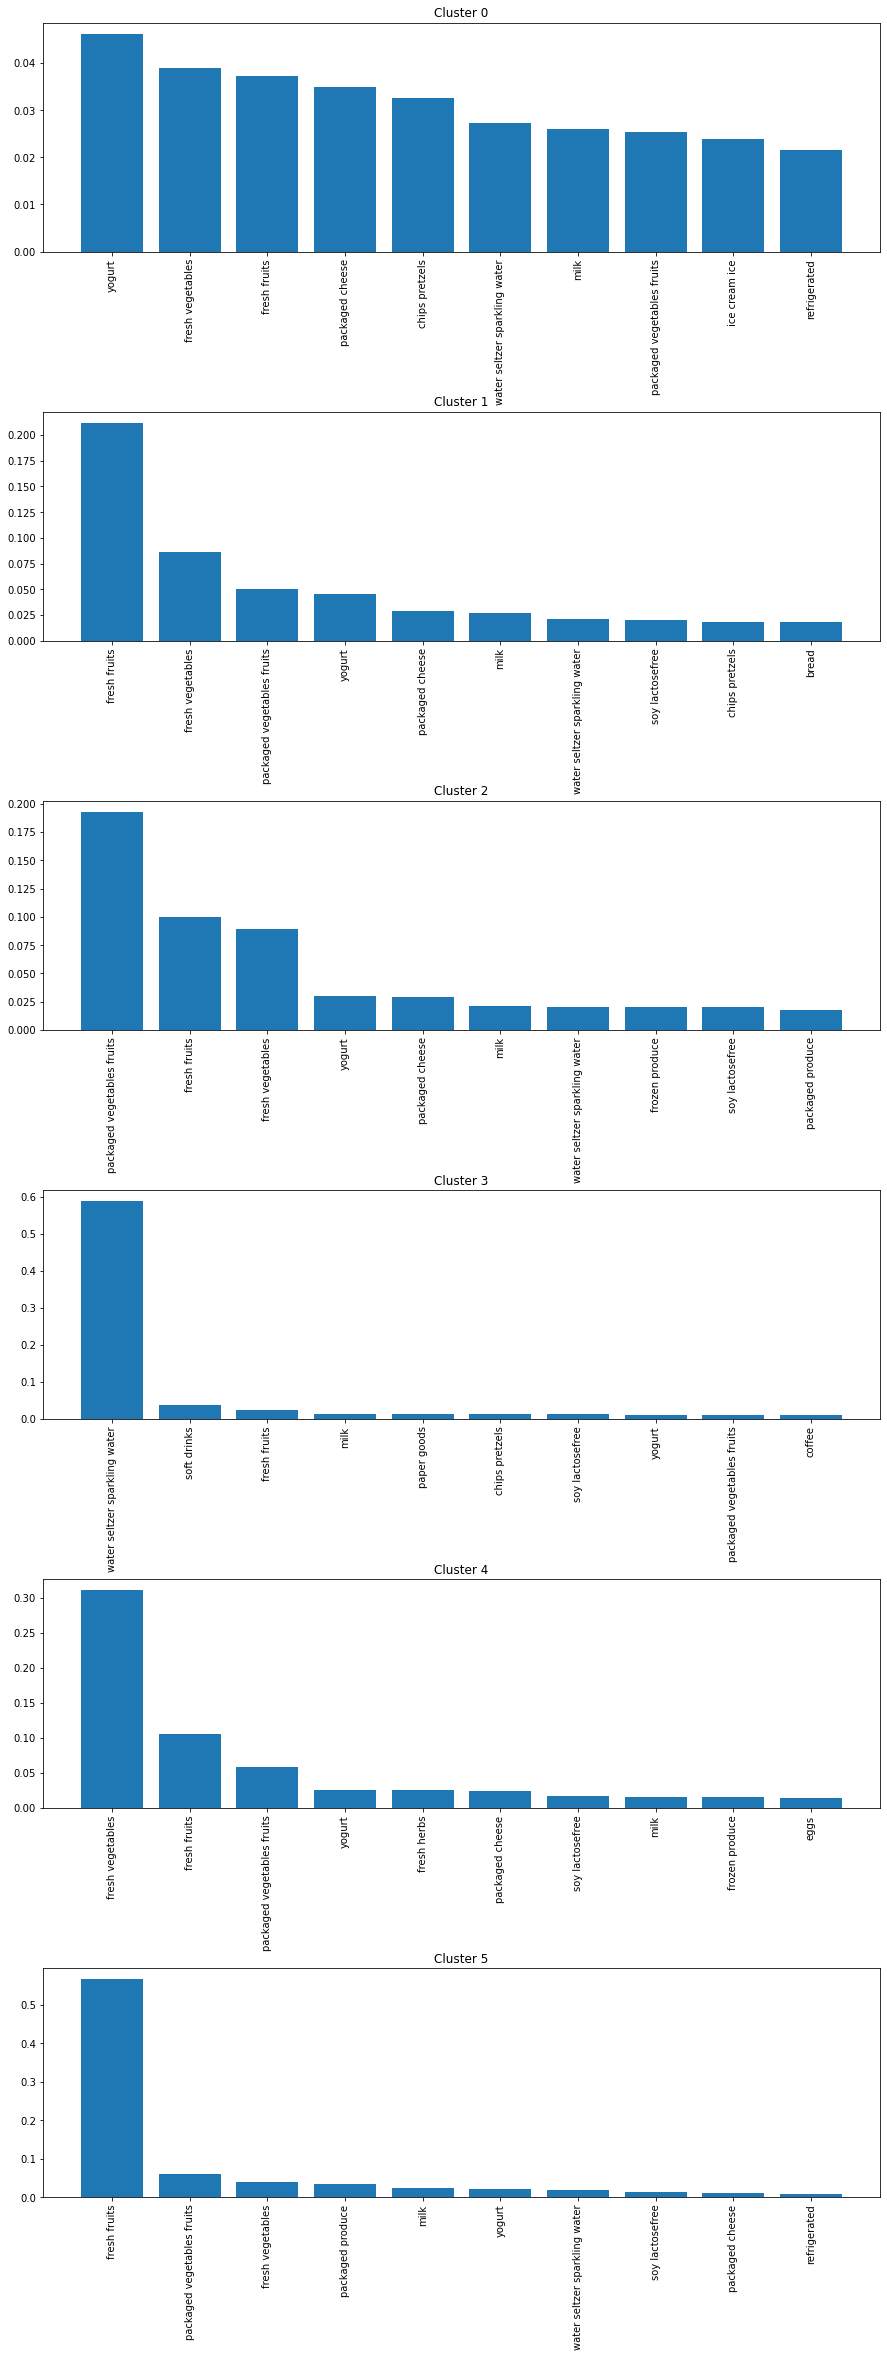

In [22]:
# Graph Top 10 Aisle in Clusters
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, figsize = (15,40))
fig.subplots_adjust(hspace=.7)
for i in range(6):
    filter_df = percent_cluster[percent_cluster['cluster'] == i].reset_index(drop=True)
    filter_df = filter_df.iloc[0:10]
    axs[i].bar(filter_df['aisle'], filter_df['percent'])
    axs[i].title.set_text(f'Cluster {i}')
    axs[i].set_xticklabels(filter_df['aisle'].unique(), rotation = 90)

# 6 Clusters Define
# (1) Cluster 2: Mainly Packaged Vege, followed by Fresh Fruits
# (2) Cluster 4: Mainly Fresh Vege, followed by Fresh Fruits
# (3) Cluster 3: Mainly Sparking Water and Other Beverages Aisles X
# (4) Cluster 1: Mainly Fresh Fruits, followed by Fresh Veges
# (5) Cluster 0: Mainly Yogurt, Balanced/Equal Aisle Distribution, followed by Fresh Vege/Fruits X
# (6) Cluster 5: Heavy on Fresh Fruits, followed by Fresh/Packaged Vege

In [23]:
percent_ct = percent_ct.reset_index(drop=False)
top_cluster = percent_ct[['user_id','cluster']]
cluster_product = order_df[['user_id', 'product_id','product_name','aisle']].merge(top_cluster, on="user_id")

In [24]:
ab = cluster_product.groupby(['cluster','product_name'])['product_id'].count().reset_index(name='count')
ab = ab.sort_values('count',ascending=False)
#ab = ab.sort_values('cluster',ascending = True)
ab.head()

,cluster,product_name,count
37031,1,Banana,8345
36936,1,Bag of Organic Bananas,7264
49750,1,Organic Strawberries,5750
2560,0,Banana,4392
44980,1,Large Lemon,3663


In [39]:
# Sort Cluster
cluster_list = sorted(ab['cluster'].unique())
inital_df = ab[ab['cluster'] == 0][0:10]

for i in range(1, len(cluster_list)):
    top_df = ab[ab['cluster'] == i][0:10]
    inital_df = pd.concat([inital_df, top_df])

cluster_top10 = inital_df
cluster_top10.head()

,cluster,product_name,count
2560,0,Banana,4392
2400,0,Bag of Organic Bananas,2493
23277,0,Organic Whole Milk,1701
30062,0,Sparkling Water Grapefruit,1305
22849,0,Organic Strawberries,1269


In [26]:
aisle_list = sorted(order_df['aisle'].unique())

## Recommendations & Test

In [27]:
test_df = order_test.merge(orders, on=['order_id'], how = 'inner')
test_df = test_df.merge(products, on=['product_id'], how = 'inner')
test_df = test_df.merge(aisles, on=['aisle_id'], how = 'inner')
test_df = test_df.merge(departments, on=['department_id'], how = 'inner')
test_user = test_df[test_df['user_id'] == 5]
test_user = test_user[test_user['order_id'] == 157374]
test_user

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs


In [29]:
# Calculate Percentage of User
percent_user = test_df.groupby(['user_id','aisle_id','aisle']).size().reset_index(name='count')

sum_userproduct = percent_user.groupby(['user_id'])['count'].sum().reset_index(name='sum')

# Merge two count and sum dataset to calculate aisle percentage
percent_user = percent_user.merge(sum_userproduct, on='user_id')
percent_user['percent'] = percent_user['count']/percent_user['sum']
percent_user.head()

,user_id,aisle_id,aisle,count,sum,percent
0,1,21,packaged cheese,8,59,0.135593
1,1,23,popcorn jerky,12,59,0.203390
2,1,24,fresh fruits,5,59,0.084746
3,1,45,candy chocolate,1,59,0.016949
4,1,53,cream,2,59,0.033898


In [36]:
percent_df = pd.pivot_table(percent_user, values='percent', index='user_id', columns = 'aisle', fill_value = 0 )
percent_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,...,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.045455,0.011364,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.0,0.000000
5,0.0,0.054054,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.081081


In [51]:
selected_user = percent_df.iloc[2,:]
selected_user

aisle
air fresheners candles           0.000000
asian foods                      0.000000
baby accessories                 0.000000
baby bath body care              0.000000
baby food formula                0.000000
                                   ...   
trash bags liners                0.000000
vitamins supplements             0.000000
water seltzer sparkling water    0.022727
white wines                      0.000000
yogurt                           0.000000
Name: 3, Length: 134, dtype: float64

In [48]:
import numpy as np
retail_user = [x for x in percent_df.iloc[0,:]]
kmeans.predict(retail_user.reshape(1, -1))

AttributeError: 'list' object has no attribute 'reshape'

In [52]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
def recommendations(user_email):
    user_email = str(user_email)
    # Convert e-mail to user_id
    user_id = int(user_df.loc[user_df['email'] == user_email, 'user_id'])
    # Fit user_id on model, return cluster 
    # kmean.fit/predict
    cluster_num = 1
    cluster_top10[cluster_top10['cluster'] == cluster_num]
    test_df[test_df['user_id'] == ]
    
    

In [74]:
cluster_top10[cluster_top10['cluster']==3]

,cluster,product_name,count
76645,3,Sparkling Water Grapefruit,361
76666,3,Spring Water,318
75600,3,Lime Sparkling Water,267
76621,3,Sparkling Lemon Water,232
76638,3,Sparkling Water,208
76626,3,Sparkling Natural Mineral Water,170
75103,3,Distilled Water,165
75792,3,Natural Spring Water,144
76622,3,Sparkling Mineral Water,143
75862,3,Orange Sparkling Water,141
